In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 194kB 26.5MB/s 
     |████████████████████████████████| 1.2MB 28.8MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key =os.environ.get('AZURE_SEARCH_KEY','2d1fd82efb8f4437b80b7ceddaed1db1')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'Nike')
ims = results.attrgot('content_url')
len(ims)

150

In [80]:
ims = ['https://ifh.cc/g/tX7mKk.jpg']

In [82]:
dest ='images/sample.jpg'
os.mkdir('images')         
download_url(ims[0],dest)

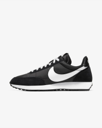

In [83]:
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
brand_types='Nike','Adidas','Reebok'
path=Path('brands')

if not path.exists():
    path.mkdir()
    for o in brand_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} brand')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
print(os.getcwd())

/content


In [10]:
fns = get_image_files(path)
fns

(#387) [Path('brands/Adidas/00000132.png'),Path('brands/Adidas/00000102.jpg'),Path('brands/Adidas/00000048.jpg'),Path('brands/Adidas/00000111.jpg'),Path('brands/Adidas/00000064.jpg'),Path('brands/Adidas/00000103.svg'),Path('brands/Adidas/00000139.jpg'),Path('brands/Adidas/00000035.jpg'),Path('brands/Adidas/00000099.jpg'),Path('brands/Adidas/00000062.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#8) [Path('brands/Adidas/00000103.svg'),Path('brands/Adidas/00000031.jpg'),Path('brands/Nike/00000112.png'),Path('brands/Nike/00000074.jpg'),Path('brands/Reebok/00000025.jpg'),Path('brands/Reebok/00000003.svg'),Path('brands/Reebok/00000044.jpg'),Path('brands/Reebok/00000032.jpg')]

In [12]:
failed.map(Path.unlink);

From data to Dataloader

In [13]:
brands = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls=brands.dataloaders(path)

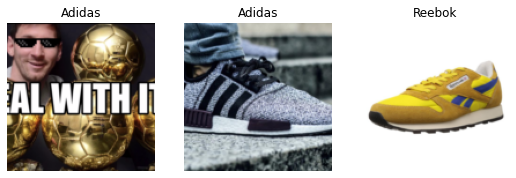

In [15]:
dls.valid.show_batch(max_n=3, nrows=1)

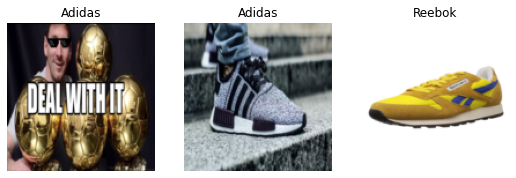

In [16]:
brands = brands.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls=brands.dataloaders(path)
dls.valid.show_batch(max_n=3,nrows=1)

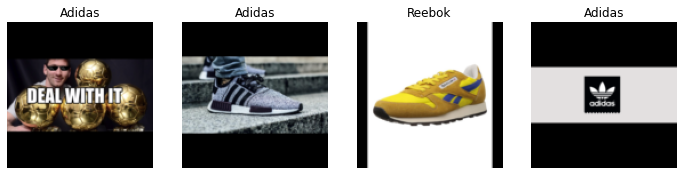

In [17]:
brands = brands.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = brands.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

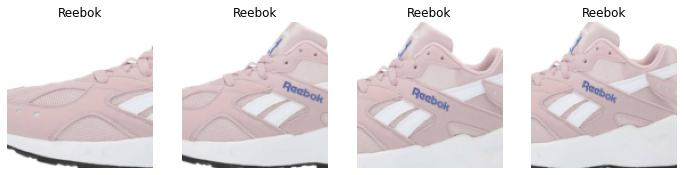

In [18]:
brands = brands.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = brands.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

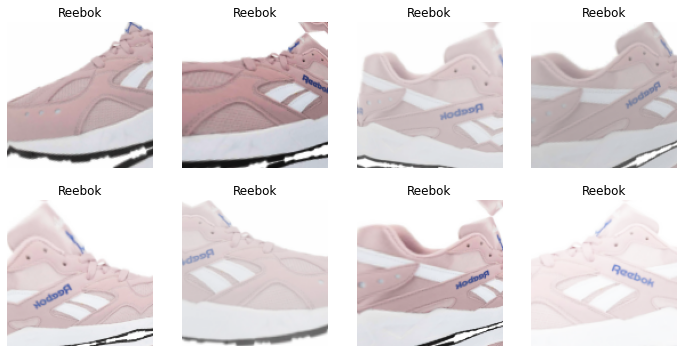

In [19]:
brands = brands.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls=brands.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training Your Model, and Using It to Clean Your Data

In [20]:
brands = brands.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = brands.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

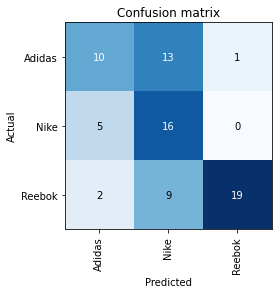

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

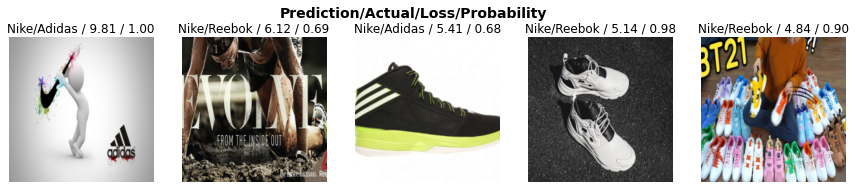

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [99]:
 #hide
 for idx in cleaner.delete(): cleaner.fns[idx].unlink()
 for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Turning Your Model into an Online Application

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
learn_inf.dls.vocab

['Adidas', 'Nike', 'Reebok']

In [92]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [84]:
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/sample.jpg'])

In [86]:
 img = PILImage.create(btn_upload.data[-1])

In [87]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [88]:
 pred,pred_idx,probs = learn_inf.predict(img)

In [89]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Nike; Probability: 0.9934')

In [90]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [91]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [93]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [95]:
VBox([widgets.Label('Select your brand (Nike/Adidas/Reebok)!'), 
      btn_upload, btn_run, out_pl, lbl_pred])